# Q:
## The number of orders per price category, current discount rate, and how to adjust it.



## Import Libraries

In [94]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

## Load Dataframe

In [2]:
# products_cl.csv
url = "https://drive.google.com/file/d/1s7Lai4NSlsYjGEPg1QSOUJobNYVsZBOJ/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
products_cl = pd.read_csv(path)

In [3]:
price_category_df = products_cl.copy()
price_category_df["category"] = ""
price_category_df.head()

,sku,name,desc,price,in_stock,type,category
0,RAI0007,Silver Rain Design mStand Support,Aluminum support compatible with all MacBook,59.99,1,8696,
1,APP0023,Apple Mac Keyboard Keypad Spanish,USB ultrathin keyboard Apple Mac Spanish.,59.00,0,13855401,
2,APP0025,Mighty Mouse Apple Mouse for Mac,mouse Apple USB cable.,59.00,0,1387,
3,APP0072,Apple Dock to USB Cable iPhone and iPod white,IPhone dock and USB Cable Apple iPod.,25.00,0,1230,
4,KIN0007,Mac Memory Kingston 2GB 667MHz DDR2 SO-DIMM,2GB RAM Mac mini and iMac (2006/07) MacBook Pr...,34.99,1,1364,


In [4]:
url = "https://drive.google.com/file/d/1pBefYYpjgSAT3JQinBwxjO6akStdMmmj/view?usp=sharing"
path = "https://drive.google.com/uc?export=download&id="+url.split("/")[-2]
orderlines = pd.read_csv(path)

In [5]:
orderlines_df = orderlines.copy()

## Create Price Categories

In [6]:
price_categories = [0, 50, 100, 200, 500]
def categorize_by_price(price):
  if price > price_categories[-1]:
    return str(price_categories[-1]) + "+"

  for lower, upper in zip(price_categories[:-1], price_categories[1:]):
    if lower < price <= upper:
      return str(lower+1) + "-" + str(upper)

In [7]:
price_category_df["category"] = price_category_df["price"].apply(categorize_by_price)

In [8]:
price_category_df.sample(5)

,sku,name,desc,price,in_stock,type,category
8896,OTT0180,OtterBox iPhone Case Etui Symmetry Black 8,Symmetry OtterBox protective sleeve one-piece ...,34.99,0,11865403,1-50
9089,BEL0338,Belkin Sport Armband Pro-Fit iPhone 8 Plus / 7...,Advanced fitness armband for iPhone 8 Plus / 7...,34.99,1,5405,1-50
4804,SAM0107,Samsung EVO + SDHC UHS Class 1 | 32GB,SDHC Memory Card U1 / UHS-I speed of 80MB / 20MB,18.39,0,11935397,1-50
7440,APP2128,"Apple iPad Pro 10.5 ""WiFi 512GB Silver",New iPad Pro 512GB Wi-Fi,1119.00,0,106431714,500+
7531,APP2108,Apple Correa 42mm Sports Amarillo Polen,Durable and flexible strap sports with clip cl...,59.00,0,2449,51-100


In [9]:
price_category_df["category"].value_counts()

,count
category,
1-50,3151
500+,2840
51-100,1714
201-500,1164
101-200,1123


## Create Discounts Dataframe

In [10]:
discounts_df = orderlines_df.merge(price_category_df, on="sku", how="inner")
discounts_df.drop(["product_id", "in_stock"], axis=1)
discounts_df["date"] = pd.to_datetime(discounts_df["date"])
discounts_df.sample(1)

,id,id_order,product_id,product_quantity,sku,unit_price,date,name,desc,price,in_stock,type,category
6167,1169232,318006,0,1,JAW0048,29.99,2017-02-01 19:16:43,Jawbone UP2 Black Rope Activity Monitor,Bluetooth activity monitor that records moveme...,119.99,0,11905404,101-200


In [11]:
discounts_df["category"].value_counts()

,count
category,
1-50,18427
51-100,13259
101-200,9616
201-500,8011
500+,3918


## Calculate Discount

In [12]:
discounts_df["unit_price_total"] = discounts_df["unit_price"] * discounts_df["product_quantity"]

In [13]:
discounts_df["discount %"] = ((discounts_df["price"] - discounts_df["unit_price_total"]) / discounts_df["price"] * 100).round(2)
discounts_df = discounts_df.loc[discounts_df["discount %"] >= 0]

In [14]:
disc_range = [0, 5, 10, 20, 30, 50]
def range_discount(discount):
  if discount >= disc_range[-1]:
    return f"{disc_range[-1]}+"
  elif discount == 0:
    return "No Discount"

  for lower, upper in zip(disc_range[:-1], disc_range[1:]):
    if lower < discount <= upper:
      return str(lower + 1) + "-" + str(upper)

In [15]:
discounts_df["discount_range"] = discounts_df["discount %"].apply(range_discount)

In [16]:
discounts_df["discount_range"].value_counts(normalize=True)

,proportion
discount_range,
11-20,0.296001
21-30,0.211441
31-50,0.141703
6-10,0.122572
50+,0.094240
1-5,0.090930
No Discount,0.043113


In [17]:
discount_order = ["No Discount", "1-5", "6-10", "11-20", "21-30", "31-50", "50+"]
price_order = ["1-50", "51-100", "101-200", "201-500", "500+"]

## Plots

### Revenue by Discount Range (colored by Price Category)

In [18]:
grouped_discounts_df = discounts_df.groupby(["discount_range", "category"]).agg(quantity=("product_quantity", "sum"),
                                                                                revenue=("unit_price_total", "sum")).reset_index()

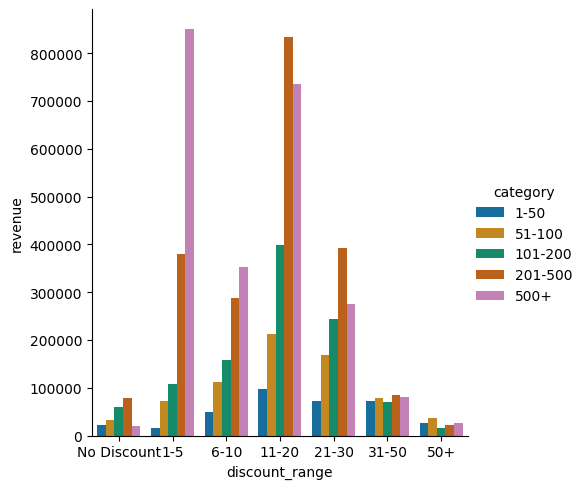

In [19]:
sns.catplot(data=grouped_discounts_df,
            x="discount_range",
            y="revenue",
            kind="bar",
            hue="category",
            palette="colorblind",
            hue_order=price_order,
            order=discount_order)

### Quantity by Discount Range (colored by Price Category)

Text(0, 0.5, 'Quantity')

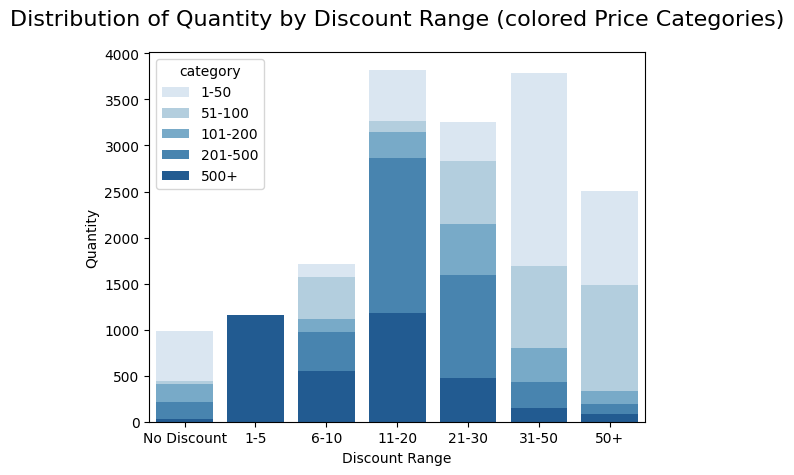

In [20]:
# Plot with barplot
bar_plot = sns.barplot(
    data=grouped_discounts_df,
    x="discount_range",
    y="quantity",
    hue="category",
    palette=sns.color_palette("Blues", len(price_order)),
    hue_order=price_order,
    order=discount_order,
    dodge=False,
)

bar_plot.set_title("Distribution of Quantity by Discount Range (colored Price Categories)", fontsize="16", y=1.05)
bar_plot.set_xlabel("Discount Range")
bar_plot.set_ylabel("Quantity")

### Total Quantity by SKU per Category

In [21]:
month = discounts_df["date"].dt.to_period("M").dt.to_timestamp()
date_price_discount_df = discounts_df.groupby([month,
                                               "category",
                                               "discount_range"]
                                              ).agg(avg_discount=("discount %", "mean"),
                                                    revenue=("unit_price_total", "sum"),
                                                    quantity=("product_quantity", "sum")
                                                    ).reset_index()

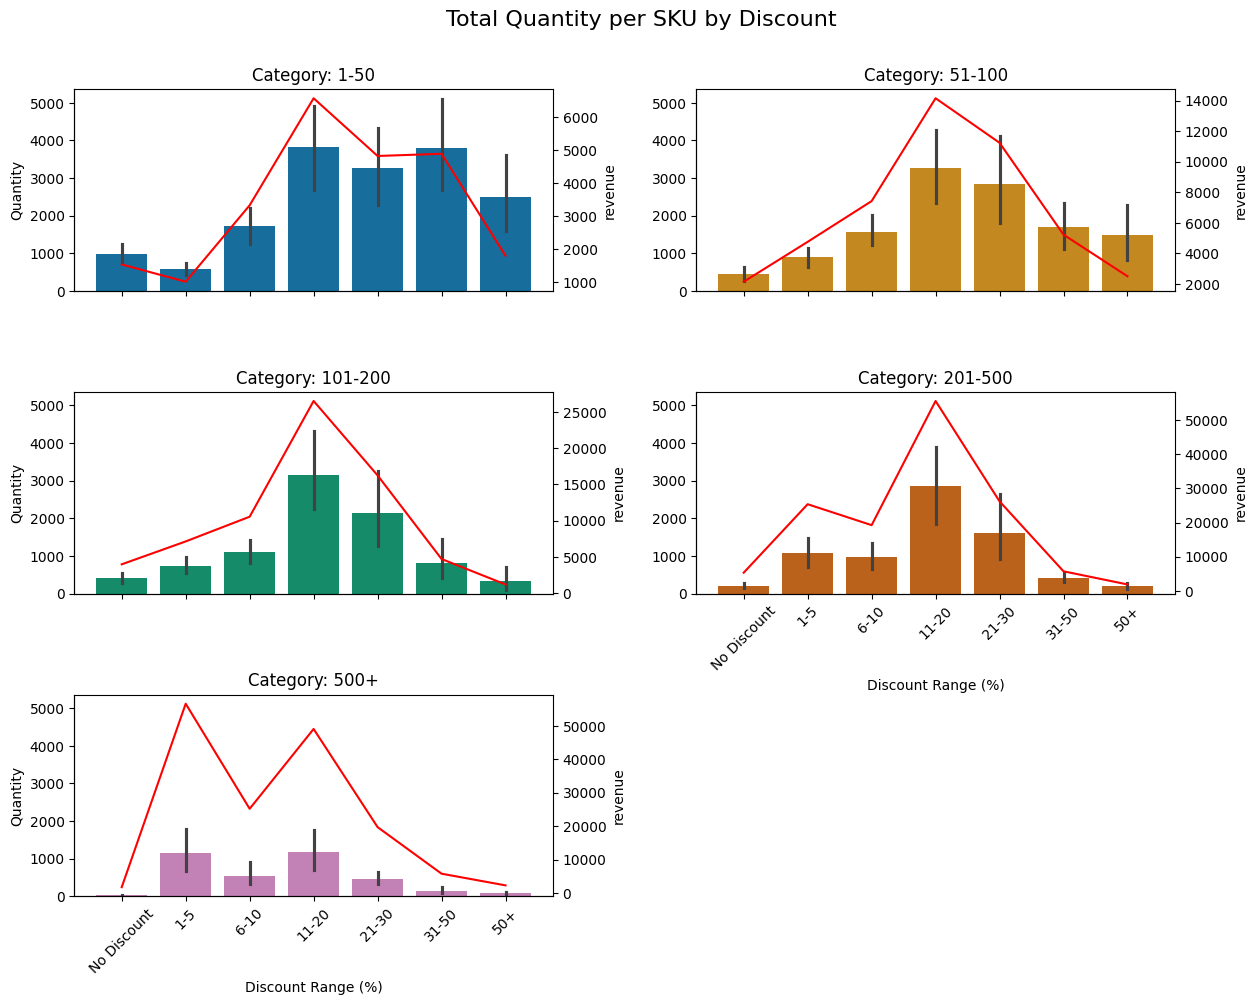

In [22]:
cat_plot = sns.catplot(data=date_price_discount_df,
                       x="discount_range",
                       y="quantity",
                       kind="bar",
                       hue="category",
                       hue_order=price_order,
                       palette="colorblind",
                       col="category",
                       col_wrap=2,
                       col_order=price_order,
                       order = discount_order,
                       height=3,
                       aspect=2,
                       estimator="sum")

cat_plot.fig.suptitle("Total Quantity per SKU by Discount", fontsize=16, y=1.05)
cat_plot.set_axis_labels("Discount Range (%)", "Quantity", fontsize=10)

for ax in cat_plot.axes.flat:
  cat = ax.get_title().split(" = ")[-1]  # extract the category name
  ax.set_title(f"Category: {cat}")

  ax2 = ax.twinx()

  data = date_price_discount_df[date_price_discount_df["category"] == cat]
  sns.lineplot(data=data,
               x="discount_range",
               y="revenue",
               ax=ax2,
               color="red",
               errorbar=None)

  for label in ax.get_xticklabels():
    label.set_rotation(45)

cat_plot.fig.subplots_adjust(hspace=0.5, wspace=0.3)
cat_plot.legend.remove()

### Total Quantity and Revenue for a Product

In [23]:
choosen_sku = "APP1922"

sku_df = discounts_df[discounts_df["sku"] == choosen_sku]

grouped_sku_df = sku_df.groupby([month,
                                 "category",
                                 "discount_range"]
                                ).agg(avg_discount=("discount %", "mean"),
                                      revenue=("unit_price_total", "sum"),
                                      quantity=("product_quantity", "sum")
                                      ).reset_index()

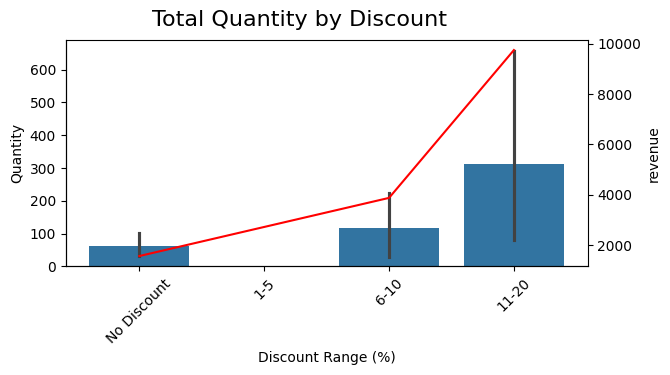

In [24]:
cat_plot = sns.catplot(data=grouped_sku_df,
                       x="discount_range",
                       y="quantity",
                       kind="bar",
                       order = discount_order,
                       sharey=False,
                       height=3,
                       aspect=2,
                       estimator="sum")

cat_plot.fig.suptitle("Total Quantity by Discount", fontsize=16, y=1.05)
cat_plot.set_axis_labels("Discount Range (%)", "Quantity", fontsize=10)

for ax in cat_plot.axes.flat:
  ax2 = ax.twinx()

  sns.lineplot(data=grouped_sku_df,
               x="discount_range",
               y="revenue",
               ax=ax2,
               color="red",
               errorbar=None)

  for label in ax.get_xticklabels():
    label.set_rotation(45)

cat_plot.fig.subplots_adjust(hspace=0.5, wspace=0.3)
cat_plot.legend.remove()

### Revenue vs Discounts By Time

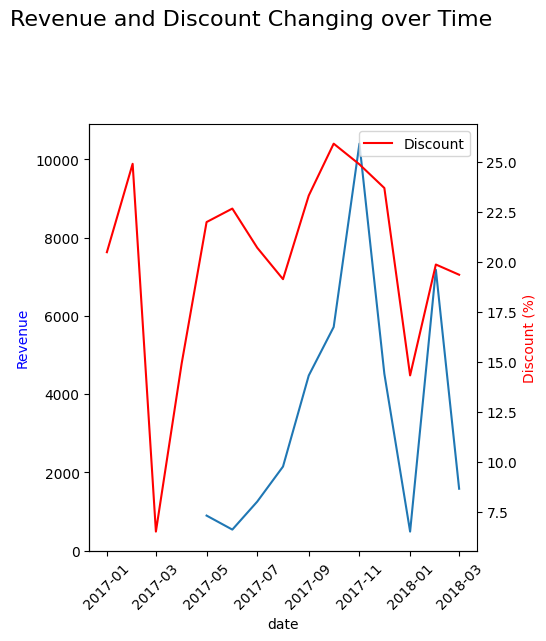

In [25]:
line_plot= sns.relplot(data=grouped_sku_df,
                       x="date",
                       y="revenue",
                       kind="line",
                       errorbar=None)

ax2 = None
for ax in line_plot.axes.flat:

  ax2 = ax.twinx()

  sns.lineplot(data=data,
               x="date",
               y="avg_discount",
               ax=ax2,
               color="red",
               label="Discount",
               errorbar=None
               )

  ax.set_ylabel("Revenue", color="blue")
  ax2.set_ylabel("")

  ax2.grid(False)   # remove background grid from second axis
  #ax2.legend(loc="upper left")

  for label in ax.get_xticklabels():
    label.set_rotation(45)

line_plot.fig.suptitle("Revenue and Discount Changing over Time", fontsize=16, y=1.2)
ax2.set_ylabel("Discount (%)", color="red")
line_plot.fig.subplots_adjust(hspace=0.3, wspace=0.2)

### Decide which Price Category to investigate

In [101]:
quantity_color = "steelblue"
revenue_color = sns.color_palette()[6]

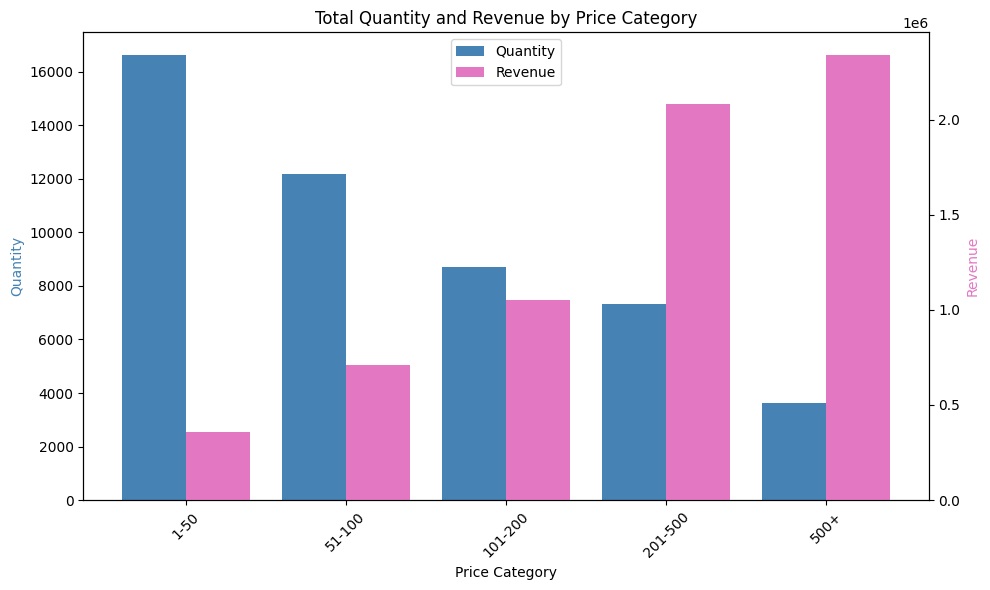

In [111]:
cats = price_order
x = np.arange(len(cats))

df_plot = discounts_df.groupby("category", as_index=False).agg({
    "unit_price_total": "sum",
    "product_quantity": "sum"
}).set_index("category").reindex(cats)

fig, ax1 = plt.subplots(figsize=(10,6))

bar_width = 0.4

bars1 = ax1.bar(
    x - bar_width/2,
    df_plot["product_quantity"],
    width=bar_width,
    color=quantity_color,
    label="Quantity"
)
ax1.set_ylabel("Quantity", color=quantity_color)

ax2 = ax1.twinx()
bars2 = ax2.bar(
    x + bar_width/2,
    df_plot["unit_price_total"],
    width=bar_width,
    color= revenue_color,
    label="Revenue"
)
ax2.set_ylabel("Revenue", color=revenue_color)

ax1.set_xticks(x)
ax1.set_xticklabels(cats, rotation=45)
ax1.set_xlabel("Price Category")
plt.title("Total Quantity and Revenue by Price Category")

bars = [bars1, bars2]
labels = ["Quantity", "Revenue"]
ax1.legend(bars, labels, loc="upper center")

plt.tight_layout()
plt.show()


* This is the result why we focused our detailed analysis on these two categories:

1.   $1–50 because of the high quantity sold,  

2.   and $500+ because of the high revenue contribution.





In [59]:
selected_price_ranges = ["1-50", "500+"]
selected_price_range_df = discounts_df[discounts_df["category"].isin(selected_price_ranges)]
selected_price_range_df.value_counts(subset="category")

,count
category,
1-50,16320
500+,3613


In [60]:
revenue_quantity_df = selected_price_range_df.groupby([month,
                                                       "category",
                                                       "discount_range"]
                                                      ).agg(revenue=("unit_price_total", "sum"),
                                                            quantity=("product_quantity", "sum")
                                                            ).reset_index()

revenue_quantity_df.sample(3)

,date,category,discount_range,revenue,quantity
73,2017-06-01,500+,21-30,21598.90,44
93,2017-08-01,1-50,11-20,6063.33,232
72,2017-06-01,500+,11-20,20447.08,33


### Investigate Selected Ranges

#### Price between \$1 and \$50

In [91]:
price_between_1_50_df = revenue_quantity_df[revenue_quantity_df["category"] == "1-50"]

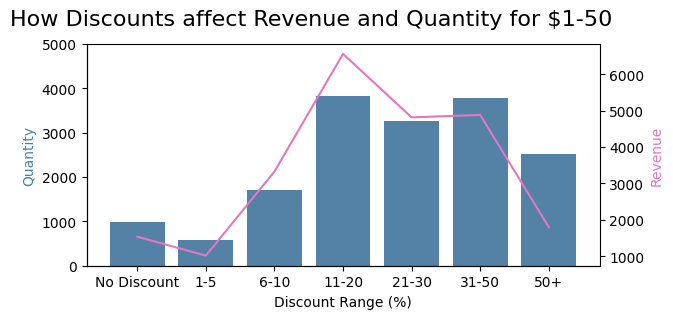

In [110]:
cat_plot = sns.catplot(data=price_between_1_50_df,
                       x="discount_range",
                       y="quantity",
                       kind="bar",
                       order = discount_order,
                       color=quantity_color,
                       height=3,
                       aspect=2,
                       estimator="sum",
                       errorbar=None)

cat_plot.fig.suptitle("How Discounts affect Revenue and Quantity for $1-50", fontsize=16, y=1.05)
cat_plot.ax.set_xlabel("Discount Range (%)")
cat_plot.ax.set_ylabel("Quantity", color=quantity_color)
cat_plot.ax.set_ylim(0, 5000)

ax2 = cat_plot.ax.twinx()

sns.lineplot(data=price_between_1_50_df,
             x="discount_range",
             y="revenue",
             ax=ax2,
             color=revenue_color,
             errorbar=None)

ax2.set_ylabel("Revenue", color=revenue_color)

for label in ax.get_xticklabels():
  label.set_rotation(45)

cat_plot.fig.subplots_adjust(hspace=0.5, wspace=0.3)
cat_plot.legend.remove()

#### Price more than \$500

In [81]:
price_more_than_500_df = revenue_quantity_df[revenue_quantity_df["category"] == "500+"]

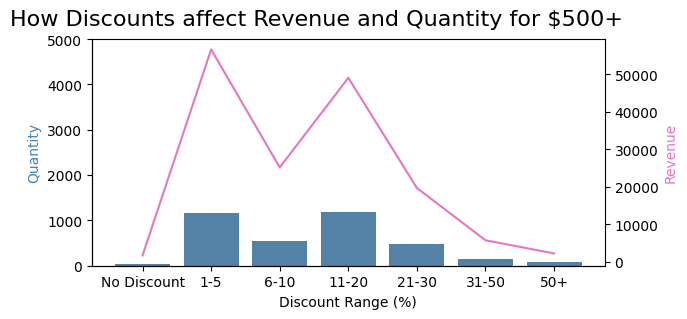

In [109]:
cat_plot = sns.catplot(data=price_more_than_500_df,
                       x="discount_range",
                       y="quantity",
                       kind="bar",
                       color=quantity_color,
                       order = discount_order,
                       height=3,
                       aspect=2,
                       estimator="sum",
                       errorbar=None)

cat_plot.fig.suptitle("How Discounts affect Revenue and Quantity for $500+", fontsize=16, y=1.05)
cat_plot.ax.set_xlabel("Discount Range (%)")
cat_plot.ax.set_ylabel("Quantity", color=quantity_color)
cat_plot.ax.set_ylim(0, 5000)

ax2 = cat_plot.ax.twinx()

sns.lineplot(data=price_more_than_500_df,
             x="discount_range",
             y="revenue",
             ax=ax2,
             color=revenue_color,
             errorbar=None)

ax2.set_ylabel("Revenue", color=revenue_color)

for label in ax.get_xticklabels():
  label.set_rotation(45)

cat_plot.fig.subplots_adjust(hspace=0.5, wspace=0.3)
cat_plot.legend.remove()